In [14]:
import os
import numpy as np
import pandas as pd
import pprint as pp
import random
import rapidfuzz
# functions for reading data from codenet:
import codenet_reader

In [15]:
# Functions for processing solutions of a problem


def pair_series(
    series_1: pd.Series,
    series_2: pd.Series,
    col_1_name: str,
    col_2_name: str,
    shuffle: bool = True,
) -> pd.DataFrame:
    assert len(series_1) == len(series_2), "Length of the series MUST match!"

    if shuffle:
        series_1 = series_1.sample(frac=1.0, ignore_index=True)
        series_2 = series_2.sample(frac=1.0, ignore_index=True)

    return pd.DataFrame({
        col_1_name: series_1.to_list(),
        col_2_name: series_2.to_list(),
    })


def process_pid(pid: str, pp_data_map: dict, np_data_map: dict, do_print=False):
    MIN_PAIRS = 5

    num_python_solutions = len(codenet_reader.python_solutions(pid))
    if num_python_solutions <= 5:
        return

    df = codenet_reader.init_metadata_df(pid)
    if df is None:
        print("ERROR: Problem metadata could not be loaded!"+
              f"\n(problem ID: {pid})\n")
        return

    df_accepted = df.loc[df["status"] == "Accepted"]
    # ONLY sample from solutions that are actually wrong
    df_rejected = df.loc[df["status"] == "Wrong Answer"]

    # TODO: use a log file for this otherwise changes get too long!
    if do_print:
        print(f"{pid}", "-" * 50)
        print(" accepted:", df_accepted.shape[0])
        print(" rejected:", df_rejected.shape[0])
    
    num_rows = min(df_accepted.shape[0], df_rejected.shape[0])
    if not num_rows or num_rows < 2 * MIN_PAIRS:
        return

    half = df_accepted.shape[0] // 2
    sr_accepted = df_accepted["submission_id"]  # all accepted IDs
    sr_accepted = sr_accepted[: 2 * half]
    # Positive pairs
    df_pp = pair_series(sr_accepted[:half], sr_accepted[half:], "sid_1", "sid_2")

    sr_accepted = df_accepted["submission_id"].sample(n=num_rows)  # num_rows IDs
    sr_rejected = df_rejected["submission_id"].sample(n=num_rows)  # num_rows IDs
    # Negative pairs
    df_np = pair_series(sr_accepted, sr_rejected, "sid_1", "sid_2", shuffle=False)

    def create_pair(pid, sid_1, sid_2, label: int):
        return {
            "pid": pid,
            "sid_1": sid_1,
            "sid_2": sid_2,
            "src_1": codenet_reader.read_solution_file(pid, sid_1),
            "src_2": codenet_reader.read_solution_file(pid, sid_2),
            "label": label,
        }

    pp_rows = [tuple(row) for _, row in df_pp.iterrows()]
    pp_data_map[pid] = [
        create_pair(pid, sid_1, sid_2, label=1) for sid_1, sid_2 in pp_rows
    ]

    np_rows = [tuple(row) for _, row in df_np.iterrows()]
    np_data_map[pid] = [
        create_pair(pid, sid_1, sid_2, label=0) for sid_1, sid_2 in np_rows
    ]

In [16]:
process_pid("p03200", {}, {}, do_print=True)

p03200 --------------------------------------------------
 accepted: 612
 rejected: 103


In [17]:
# Reading data

SAMPLE_SIZE = 2000  # Number of problems to sample from

_pids = os.listdir(codenet_reader.DATA_PATH)
_pids = random.sample(_pids, k=min(SAMPLE_SIZE, len(_pids)))

pp_data = {}
np_data = {}

print("Starting...")
print(f"Processing {len(_pids)} problems.")

for _pid in _pids:
    process_pid(_pid, pp_data, np_data)

print("Data gathered...")

pp_output = []
for pid in pp_data:
    for data in pp_data[pid]:
        pp_output.append(
            (
                pid,
                data["sid_1"],
                data["sid_2"],
                data["src_1"],
                data["src_2"],
                data["label"],
            )
        )

np_output = []
for pid in np_data:
    for data in np_data[pid]:
        np_output.append(
            (
                pid,
                data["sid_1"],
                data["sid_2"],
                data["src_1"],
                data["src_2"],
                data["label"],
            )
        )

print(f"POSITIVE pairs created... LENGTH: {len(pp_output)}")
print(f"NEGATIVE pairs created... LENGTH: {len(np_output)}")

pp_output = sorted(set(pp_output), key=lambda x: (x[0], x[1]))
np_output = sorted(set(np_output), key=lambda x: (x[0], x[1]))

pp_len, np_len = len(pp_output), len(np_output)

print(f"POSITIVE pair content filtered... LENGTH: {pp_len}")
print(f"NEGATIVE pair content filtered... LENGTH: {np_len}")

print("DONE")

columns = ["pid", "sid_1", "sid_2", "src_1", "src_2", "label"]
# positive pairs
pp_output = pd.DataFrame(pp_output, columns=columns)
# negative pairs
np_output = pd.DataFrame(np_output, columns=columns)

Starting...
Processing 2000 problems.
Data gathered...
POSITIVE pairs created... LENGTH: 215830
NEGATIVE pairs created... LENGTH: 166341
POSITIVE pair content filtered... LENGTH: 215830
NEGATIVE pair content filtered... LENGTH: 166341
DONE


In [18]:
MAX_CHAR_COUNT = 4096
# Filter to pairs that have a combined length of less than `MAX_CHAR_COUNT` characters
filter = lambda row: len(row['src_1']) + len(row['src_2']) < MAX_CHAR_COUNT
pp_output = pp_output[pp_output.apply(filter, axis=1)]
np_output = np_output[np_output.apply(filter, axis=1)]
print(pp_output.shape)
print(np_output.shape)

(213708, 6)
(163985, 6)


In [19]:
# Calculating rapid fuzz

def run_rf(a,b): return rapidfuzz.fuzz.ratio(a,b)

pp_output['rf_ratio'] = pp_output.apply(lambda row: run_rf(row['src_1'], row['src_2']), axis=1)
np_output['rf_ratio'] = np_output.apply(lambda row: run_rf(row['src_1'], row['src_2']), axis=1)

In [20]:
# Rapid fuzz counts
print('pp gt 80%:', (pp_output['rf_ratio']>80).sum())
print('np gt 80%:', (np_output['rf_ratio']>80).sum())

pp gt 80%: 14371
np gt 80%: 2326


Text(0.5, 0, 'rf ratio on positive pairs')

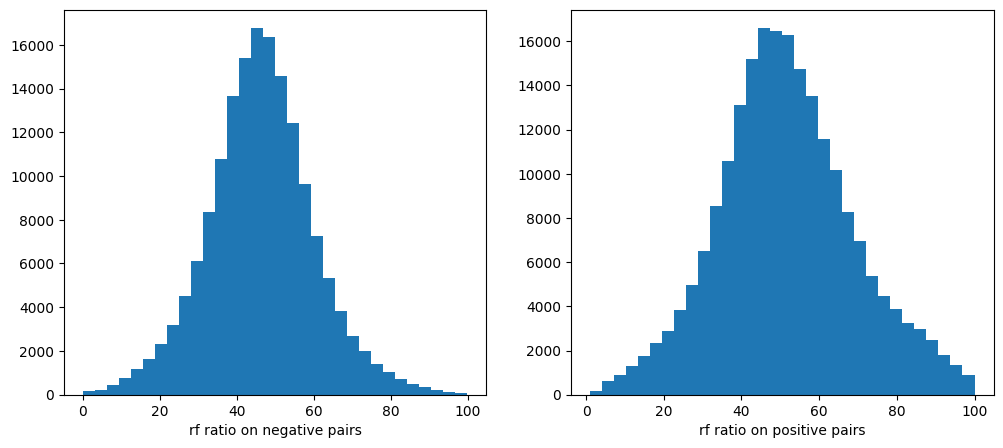

In [21]:
# Rapid fuzz histograms
import matplotlib.pyplot as plt
res = 32
# histogram
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
ax[0].hist(np_output['rf_ratio'], bins=res)
ax[0].set_xlabel('rf ratio on negative pairs')
ax[1].hist(pp_output['rf_ratio'], bins=res)
ax[1].set_xlabel('rf ratio on positive pairs')

In [22]:
NUM_PAIRS = 50_000

# Filtering and sampling
pp_output = pp_output.sample(NUM_PAIRS)
#np_output = np_output[np_output['rf_ratio'] > 80]
np_output = np_output.sample(NUM_PAIRS)

In [23]:
# Exporting
EXPORTED_FILE_NAME = 'output_paired.csv'
pp_output = pp_output[columns]
np_output = np_output[columns]
output = pd.concat([pp_output, np_output], ignore_index=True)
output.to_csv(EXPORTED_FILE_NAME, index=None)

In [ ]:
df = pd.read_csv(EXPORTED_FILE_NAME)
print("Sampled", len(set(df['pid'])), "problems.")
df

Sampled 524 problems.


,pid,sid_1,sid_2,src_1,src_2,label
0,p02677,s234832019,s655531330,"import math\n\na, b, h, m = map(int, input().s...","import math\nA,B,H,M=map(int,input().split())\...",1
1,p02645,s090771357,s730130061,n = input()\nprint(n[0:3]),\ns = input()\nprint(s[:3]),1
2,p02707,s692462118,s491685340,"n=int(input())\na=sorted(list(map(int,input()....","n = int(input())\na = list(map(int, input().sp...",1
3,p03250,s213551843,s362461591,# -*- coding: utf-8 -*-\n\ns = sorted(list(map...,"a,b,c = sorted(map(int,input().split()))\n\npr...",1
4,p02820,s365411396,s473065485,"N, K = map(int,input().split())\nR,S,P = map(i...","n, k = map(int, input().split())\ns, p, r = ma...",1
...,...,...,...,...,...,...
99995,p02747,s546103424,s773912093,import sys\n\ninput = sys.stdin.readline().str...,import sys\ns = input()\nn = 0\nfor i in range...,0
99996,p03944,s607238482,s766340564,import sys\nreadline = sys.stdin.buffer.readli...,"W, H, n = map(int, input().split())\n\none = 0...",0
99997,p02724,s246457803,s393370890,import math\n\nline = input()\nmoney = int(lin...,x = int(input())\nif x >= 500:\n a = int(x/50...,0
99998,p03074,s011840012,s755408814,"from itertools import accumulate as ac\n\nN, K...","n,k = map(int,input().split())\ns = input()\nL...",0
